# Trying out ensemble methods (stacking)

Combination of multiple learning models can result in a higher prediction capability compared to any of the models used. This technique is very powerful in Kaggle, to win machine learning competitions and to improve the performance of models significantly. This python notebook uses one of the ensemble methods (stacking) to improve the predictive capability for a machine learning competition on predicting earthquake building damage.

In [2]:
import os
import math
import pandas as pd
from joblib import dump, load
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import GridSearchCV, KFold, cross_validate, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingCVClassifier
import xgboost as xgb
from helper import plot_confusion_matrix

## Read in and preprocess dataset with feature engineering

In [5]:
ROOT_PATH = '.'

In [6]:
X_train = pd.read_csv(os.path.join(ROOT_PATH, "data", "split_train_values.csv"))
y_train = pd.read_csv(os.path.join(ROOT_PATH, "data", "split_train_labels.csv")).iloc[:,0]
X_test = pd.read_csv(os.path.join(ROOT_PATH, "data", "split_test_values.csv"))
y_test = pd.read_csv(os.path.join(ROOT_PATH, "data",  "split_test_labels.csv")).iloc[:,0]

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [7]:
class PreprocessorLog1(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        pass
    
    def transform(self, X, *_):
        new_X = self._preprocess_input(X)
        return new_X
    
    def fit(self, X, *_):
        return self
    
    # courtesy of pham minh
    def _preprocess_input(self, X):
        df_X = pd.DataFrame(X, columns=self.columns)
        # Turn age feature into log(age)
        if ("log10(age+1)" not in df_X.columns) and ("age" in df_X.columns):
            df_X["log10(age+1)"] = df_X["age"].transform(lambda x: np.log10(x + 1))
            df_X.drop("age", axis = 1, inplace = True)
        # Drop unnecessary features
        dropped_features = [
            "has_secondary_use",
            "has_secondary_use_agriculture",
            "has_secondary_use_hotel",
            "has_secondary_use_rental",
            "has_secondary_use_institution",
            "has_secondary_use_school",
            "has_secondary_use_industry",
            "has_secondary_use_health_post",
            "has_secondary_use_gov_office",
            "has_secondary_use_use_police",
            "has_secondary_use_other"
        ]
        for feature in dropped_features:
            if feature in df_X.columns:
                df_X.drop(feature, axis = 1, inplace = True)
        # Turn all category features into multiple one-hot features
        df_X = pd.get_dummies(df_X)
        return df_X.values

## Setting up models to stack

In [8]:
lr1 = LogisticRegression(solver="saga", multi_class="ovr", max_iter=10000, tol=0.001,
                       C=100, penalty='l2')
lrpipe = make_pipeline(PreprocessorLog1(X_train.columns), MinMaxScaler(), lr1)
print(lrpipe)

Pipeline(memory=None,
         steps=[('preprocessorlog1',
                 PreprocessorLog1(columns=Index(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id',
       'count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage',
       'has_superstructure_adobe_mud', 'has_superstructure_mud_mortar_stone',
       'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_supers...
      dtype='object'))),
                ('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))),
                ('logisticregression',
                 LogisticRegression(C=100, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=10000,
                                    multi_class='ovr', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='saga', tol=0.001, verbose=0,

In [10]:
xgb1 = xgb.XGBClassifier(random_state=2000, n_jobs=15, reg_lambda=0, learning_rate=0.2, objective='multi:softmax',
                       max_depth=10, subsample=0.8, colsample_bytree=0.8, min_child_weight=3, reg_alpha=1, n_estimators=200)
xgbpipe = make_pipeline(StandardScaler(), xgb1)
print(xgbpipe)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.8, gamma=0, learning_rate=0.2,
                               max_delta_step=0, max_depth=10,
                               min_child_weight=3, missing=None,
                               n_estimators=200, n_jobs=15, nthread=None,
                               objective='multi:softmax', random_state=2000,
                               reg_alpha=1, reg_lambda=0, scale_pos_weight=1,
                               seed=None, silent=None, subsample=0.8,
                               verbosity=1))],
         verbose=False)


In [11]:
rf = RandomForestClassifier(random_state=2000, max_depth=34, max_features=56, min_samples_leaf=4,
                           min_samples_split=0.1, n_estimators=12)
rfpipe = make_pipeline(StandardScaler(), rf)
print(rfpipe)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=34,
                                        max_features=56, max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=4,
                                        min_samples_split=0.1,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=12, n_jobs=None,
                                        oob_score=False, random_state=2000,
                                        verbose=0, warm_start=False))],
         verbose=False)


In [12]:
RANDOM_SEED = 1000
lr2 = LogisticRegression(random_state=1000, C=10000)
sclf = StackingCVClassifier(classifiers=[rfpipe, lrpipe, xgbpipe],
                           meta_classifier=lr2,
                           random_state = RANDOM_SEED, use_probas=True)
print(sclf)

StackingCVClassifier(classifiers=[Pipeline(memory=None,
                                           steps=[('standardscaler',
                                                   StandardScaler(copy=True,
                                                                  with_mean=True,
                                                                  with_std=True)),
                                                  ('randomforestclassifier',
                                                   RandomForestClassifier(bootstrap=True,
                                                                          class_weight=None,
                                                                          criterion='gini',
                                                                          max_depth=34,
                                                                          max_features=56,
                                                                          max_leaf_nodes=None,
       

## Hyperparameter tuning

In [16]:
def save_cv(cv_results_, filepath):
    cv_results = pd.DataFrame(cv_results_)
    cv_results.to_csv(filepath)

In [17]:
hp_space = {'meta_classifier__C': [1, 10, 100]    
}

gscv = GridSearchCV(estimator=sclf, 
                    param_grid=hp_space, 
                    cv=5,
                    refit=True)
print(gscv)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=StackingCVClassifier(classifiers=[Pipeline(memory=None,
                                                                  steps=[('standardscaler',
                                                                          StandardScaler(copy=True,
                                                                                         with_mean=True,
                                                                                         with_std=True)),
                                                                         ('randomforestclassifier',
                                                                          RandomForestClassifier(bootstrap=True,
                                                                                                 class_weight=None,
                                                                                                 criterion='gini',
                      

In [18]:
gscv.fit(X_train, y_train)

/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=StackingCVClassifier(classifiers=[Pipeline(memory=None,
                                                                  steps=[('standardscaler',
                                                                          StandardScaler(copy=True,
                                                                                         with_mean=True,
                                                                                         with_std=True)),
                                                                         ('randomforestclassifier',
                                                                          RandomForestClassifier(bootstrap=True,
                                                                                                 class_weight=None,
                                                                                                 criterion='gini',
                      

In [19]:
print("Finished training SCLF with grid search CV. Saving model...")
print("All ")
print("Best params: {}".format(gscv.best_params_))
print("Best Micro F1 score: {}".format(gscv.best_score_))
print("Summary of CV_results: {}".format(gscv.cv_results_.keys()))
save_cv(gscv.cv_results_, os.path.join(ROOT_PATH, "results", "sclf_grid1.csv"))

Finished training SVC with grid search CV. Saving model...
All 
Best params: {'meta_classifier__C': 10}
Best Micro F1 score: 0.656
Summary of CV_results: dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_meta_classifier__C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])


In [21]:
hp_space2 = {'meta_classifier__C': [10, 100, 1000]    
}

gscv2 = GridSearchCV(estimator=sclf, 
                    param_grid=hp_space2, 
                    cv=5,
                    refit=True)
print(gscv2)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=StackingCVClassifier(classifiers=[Pipeline(memory=None,
                                                                  steps=[('standardscaler',
                                                                          StandardScaler(copy=True,
                                                                                         with_mean=True,
                                                                                         with_std=True)),
                                                                         ('randomforestclassifier',
                                                                          RandomForestClassifier(bootstrap=True,
                                                                                                 class_weight=None,
                                                                                                 criterion='gini',
                      

In [22]:
gscv2.fit(X_train, y_train)

/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=StackingCVClassifier(classifiers=[Pipeline(memory=None,
                                                                  steps=[('standardscaler',
                                                                          StandardScaler(copy=True,
                                                                                         with_mean=True,
                                                                                         with_std=True)),
                                                                         ('randomforestclassifier',
                                                                          RandomForestClassifier(bootstrap=True,
                                                                                                 class_weight=None,
                                                                                                 criterion='gini',
                      

In [23]:
print("Finished training SCLF with grid search CV 2. Saving model...")
print("All ")
print("Best params: {}".format(gscv2.best_params_))
print("Best Micro F1 score: {}".format(gscv2.best_score_))
print("Summary of CV_results: {}".format(gscv2.cv_results_.keys()))
print(gscv2.cv_results_)
save_cv(gscv2.cv_results_, os.path.join(ROOT_PATH, "results", "sclf_grid2.csv"))

Finished training SVC with grid search CV 2. Saving model...
All 
Best params: {'meta_classifier__C': 10}
Best Micro F1 score: 0.656
Summary of CV_results: dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_meta_classifier__C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])
{'mean_fit_time': array([1.70731521, 1.70696821, 1.71169915]), 'std_fit_time': array([0.02757569, 0.02635844, 0.02671279]), 'mean_score_time': array([0.03501797, 0.03463244, 0.03447952]), 'std_score_time': array([0.0008895 , 0.00024941, 0.00028586]), 'param_meta_classifier__C': masked_array(data=[10, 100, 1000],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'meta_classifier__C': 10}, {'meta_classifier__C': 100}, {'meta_classifier__C': 1000}], 'split0_test_score': array([0.65174129, 0.65174129, 0.65174

In [26]:
hp_space3 = {'meta_classifier__C': [1000, 10000]
}

gscv3 = GridSearchCV(estimator=sclf, 
                    param_grid=hp_space3, 
                    cv=5,
                    refit=True)
print(gscv3)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=StackingCVClassifier(classifiers=[Pipeline(memory=None,
                                                                  steps=[('standardscaler',
                                                                          StandardScaler(copy=True,
                                                                                         with_mean=True,
                                                                                         with_std=True)),
                                                                         ('randomforestclassifier',
                                                                          RandomForestClassifier(bootstrap=True,
                                                                                                 class_weight=None,
                                                                                                 criterion='gini',
                      

In [27]:
gscv3.fit(X_train, y_train)

/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=StackingCVClassifier(classifiers=[Pipeline(memory=None,
                                                                  steps=[('standardscaler',
                                                                          StandardScaler(copy=True,
                                                                                         with_mean=True,
                                                                                         with_std=True)),
                                                                         ('randomforestclassifier',
                                                                          RandomForestClassifier(bootstrap=True,
                                                                                                 class_weight=None,
                                                                                                 criterion='gini',
                      

In [28]:
print("Finished training SCLF with grid search CV 3. Saving model...")
print("All ")
print("Best params: {}".format(gscv3.best_params_))
print("Best Micro F1 score: {}".format(gscv3.best_score_))
print("Summary of CV_results: {}".format(gscv3.cv_results_.keys()))
    
save_cv(gscv3.cv_results_, os.path.join(ROOT_PATH, "results", "sclf_grid3.csv"))

Finished training SCLF with grid search CV 3. Saving model...
All 
Best params: {'meta_classifier__C': 1000}
Best Micro F1 score: 0.655
Summary of CV_results: dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_meta_classifier__C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])


In [29]:
best_sclf = gscv3.best_estimator_
y_pred = best_sclf.predict(X_test)
print("Micro F1 score(Stacking): {}".format(f1_score(y_test, y_pred, average='micro', labels=[1, 2, 3])))

Micro F1 score(Stacking): 0.6415716971720195


In [30]:
with open(os.path.join(ROOT_PATH, "results", 'sclf_output.txt'), 'a+') as fp:
    print("Finished training SVC with grid search CV 3. Saving model...", file=fp)
    print("All ", file=fp)
    print("Best params: {}".format(gscv3.best_params_), file=fp)
    print("Best Micro F1 score: {}".format(gscv3.best_score_), file=fp)
    print("Summary of CV_results: {}".format(gscv3.cv_results_.keys()), file=fp)
    best_sclf = gscv3.best_estimator_
    y_pred = best_sclf.predict(X_test)
    print("Micro F1 score(Stacking): {}".format(f1_score(y_test, y_pred, average='micro', labels=[1, 2, 3])))

Micro F1 score(Stacking): 0.6415716971720195


### Save tuned model

In [31]:
from joblib import dump

dump(best_sclf, os.path.join('models', 'sclf.joblib'))

['models/sclf.joblib']

## Try out new models to stack

In [41]:
from joblib import load
import os

sclf = load(os.path.join('models', 'sclf.joblib'))
print(sclf)

In [42]:
class PreprocessorXGB2(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        pass
    
    def transform(self, X, *_):
        new_X = self._preprocess_input(X)
        return new_X
    
    def fit(self, X, *_):
        return self
    
    def _preprocess_input(self, X):
        df_X = pd.DataFrame(X, columns=self.columns)
        features_sec_use = [col for col in df_X.columns if 'has_secondary_use_' in col]
        df_X['has_secondary_uses'] = df_X[features_sec_use[0]]
        for i in range(1, len(features_sec_use)):
            df_X['has_secondary_uses'] |= df_X[features_sec_use[i]]
        df_X.drop(columns=['has_secondary_use'], inplace=True)
        # Turn all category features into multiple one-hot features
        df_X = pd.get_dummies(df_X)
        return df_X.values

In [43]:
class PreprocessorXGB3(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        pass
    
    def transform(self, X, *_):
        new_X = self._preprocess_input(X)
        return new_X
    
    def fit(self, X, *_):
        return self
    
    def _preprocess_input(self, X):
        df_X = pd.DataFrame(X, columns=self.columns)
        # Commented means not good
        #     df['area_height_ratio'] = df['area_percentage'] / df['height_percentage']
        df_X['count_floors_height_ratio'] = df_X['count_floors_pre_eq'] / df_X['height_percentage']
        #     df['age_count_floors_pre_eq_ratio'] = df['age'] / df['count_floors_pre_eq']
        df_X = pd.get_dummies(df_X)
        return df_X.values

### Test stacking(combined_secondary)

In [44]:
rfpipe = sclf.clfs_[0]
lrpipe = sclf.clfs_[1]
meta_clf = sclf.meta_clf_

xgb1 = xgb.XGBClassifier(random_state=2000, n_jobs=15, reg_lambda=0, learning_rate=0.2, objective='multi:softmax',
                       max_depth=10, subsample=0.8, colsample_bytree=0.8, min_child_weight=3, reg_alpha=1, n_estimators=200)
xgbpipe = make_pipeline(PreprocessorXGB2(X_train.columns), StandardScaler(), xgb1)

RANDOM_SEED = 1000
new_sclf = StackingCVClassifier(classifiers=[rfpipe, lrpipe, xgbpipe],
                           meta_classifier=meta_clf,
                           random_state = RANDOM_SEED, use_probas=True)
print(new_sclf)

In [45]:
scores = cross_val_score(new_sclf, X_train, y_train, 
                                              cv=5, scoring='f1_micro')

/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:

In [46]:
import sys
fp = open(os.path.join(ROOT_PATH, "results", 'sclf_results.txt'), 'a+')
original = sys.stdout
sys.stdout = fp
print('SCLF with XGB(combined_secondaries)')
print("F1-score: %0.4f (+/- %0.4f)" 
      % (scores.mean(), scores.std()))
print("************************************************************************************")
sys.stdout = original
fp.close()
# print("Finish writing to sclf_results.txt")

In [47]:
from joblib import load, dump
import os

dump(new_sclf, os.path.join('models', 'sclf2.joblib'))

['models/sclf2.joblib']

### Test stacking(make_ratio)

In [48]:
rfpipe = sclf.clfs_[0]
lrpipe = sclf.clfs_[1]
meta_clf = sclf.meta_clf_

xgb2 = xgb.XGBClassifier(random_state=2000, n_jobs=15, reg_lambda=0, learning_rate=0.2, objective='multi:softmax',
                       max_depth=10, subsample=0.8, colsample_bytree=0.8, min_child_weight=3, reg_alpha=1, n_estimators=200)
xgbpipe2 = make_pipeline(PreprocessorXGB3(X_train.columns), StandardScaler(), xgb2)

RANDOM_SEED = 1000
new_sclf2 = StackingCVClassifier(classifiers=[rfpipe, lrpipe, xgbpipe2],
                           meta_classifier=meta_clf,
                           random_state = RANDOM_SEED, use_probas=True)
print(new_sclf2)

In [49]:
scores = cross_val_score(new_sclf2, X_train, y_train, 
                                              cv=5, scoring='f1_micro')

/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:

In [52]:
import sys
fp = open(os.path.join(ROOT_PATH, "results", 'sclf_results.txt'), 'a+')
original = sys.stdout
sys.stdout = fp
print('SCLF with XGB(make_ratio)')
print("F1-score: %0.3f (+/- %0.3f)" 
      % (scores.mean(), scores.std()))
print("************************************************************************************")
sys.stdout = original
fp.close()
print("Finish writing to sclf_results.txt")

In [54]:
new_sclf2.fit(X_train, y_train)

/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


StackingCVClassifier(classifiers=[Pipeline(memory=None,
                                           steps=[('standardscaler',
                                                   StandardScaler(copy=True,
                                                                  with_mean=True,
                                                                  with_std=True)),
                                                  ('randomforestclassifier',
                                                   RandomForestClassifier(bootstrap=True,
                                                                          class_weight=None,
                                                                          criterion='gini',
                                                                          max_depth=34,
                                                                          max_features=56,
                                                                          max_leaf_nodes=None,
       

In [55]:
y_pred = new_sclf2.predict(X_test)
print('F1-score (micro): {}'.format(f1_score(y_pred, y_test, average='micro')))

In [56]:
from joblib import load
import os

dump(new_sclf2, os.path.join('models', 'sclf3.joblib'))

['models/sclf3.joblib']

### Test stacking(improved rf)

In [57]:
from joblib import load
import os

sclf = load(os.path.join('models', 'sclf3.joblib'))
rf_clf = load(os.path.join('models', 'rfv2.joblib'))

In [58]:
rfpipe = make_pipeline(StandardScaler(), rf_clf)
lrpipe = sclf.clfs_[1]
xgbpipe3 = sclf.clfs_[2]
meta_clf = sclf.meta_clf_

RANDOM_SEED = 1000
new_sclf3 = StackingCVClassifier(classifiers=[rfpipe, lrpipe, xgbpipe3],
                           meta_classifier=meta_clf,
                           random_state = RANDOM_SEED, use_probas=True)
print(new_sclf3)

In [59]:
scores = cross_val_score(new_sclf3, X_train, y_train, 
                                              cv=5, scoring='f1_micro')

/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:

In [60]:
import sys
fp = open(os.path.join(ROOT_PATH, "results", 'sclf_results.txt'), 'a+')
original = sys.stdout
sys.stdout = fp
print('SCLF with XGB(improved rf)')
print("F1-score: %0.7f (+/- %0.7f)" 
      % (scores.mean(), scores.std()))
print("************************************************************************************")
sys.stdout = original
fp.close()
print("Finish writing to sclf_results.txt")

In [61]:
new_sclf3.fit(X_train, y_train)

/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


StackingCVClassifier(classifiers=[Pipeline(memory=None,
                                           steps=[('standardscaler',
                                                   StandardScaler(copy=True,
                                                                  with_mean=True,
                                                                  with_std=True)),
                                                  ('pipeline',
                                                   Pipeline(memory=None,
                                                            steps=[('standardscaler',
                                                                    StandardScaler(copy=True,
                                                                                   with_mean=True,
                                                                                   with_std=True)),
                                                                   ('randomforestclassifier',
                        

In [62]:
y_pred = new_sclf3.predict(X_test)
print('F1-score (micro): {}'.format(f1_score(y_pred, y_test, average='micro')))

In [63]:
from joblib import load
import os

dump(new_sclf3, os.path.join('models', 'sclf4.joblib'))

['models/sclf4.joblib']

### Stacking (Min Max scaler)

In [65]:
from joblib import load
from sklearn.preprocessing import MinMaxScaler
import os
from helper import *

sclf = load(os.path.join('models', 'sclf4.joblib'))
rf_clf = load(os.path.join('models', 'rfv2.joblib'))

In [68]:
rfpipe = make_pipeline(MinMaxScaler(), rf_clf)
lrpipe = sclf.clfs_[1]
xgbpipe3 = sclf.clfs_[2]
# change to min max scaler
xgbpipe3.steps[1] = ('minmaxscaler', MinMaxScaler())
print(xgbpipe3)
meta_clf = sclf.meta_clf_

RANDOM_SEED = 1000
new_sclf4 = StackingCVClassifier(classifiers=[rfpipe, lrpipe, xgbpipe3],
                           meta_classifier=meta_clf,
                           random_state = RANDOM_SEED, use_probas=True)
print(new_sclf3)

In [69]:
scores = cross_val_score(new_sclf4, X_train, y_train, 
                                              cv=5, scoring='f1_micro')

/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:

In [70]:
import sys
fp = open(os.path.join(ROOT_PATH, "results", 'sclf_results.txt'), 'a+')
original = sys.stdout
sys.stdout = fp
print('SCLF with XGB(min max)')
print("F1-score: %0.7f (+/- %0.7f)" 
      % (scores.mean(), scores.std()))
print("************************************************************************************")
sys.stdout = original
fp.close()
print("Finish writing to sclf_results.txt")

In [71]:
new_sclf4.fit(X_train, y_train)

/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/tenvinc/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


StackingCVClassifier(classifiers=[Pipeline(memory=None,
                                           steps=[('minmaxscaler',
                                                   MinMaxScaler(copy=True,
                                                                feature_range=(0,
                                                                               1))),
                                                  ('pipeline',
                                                   Pipeline(memory=None,
                                                            steps=[('standardscaler',
                                                                    StandardScaler(copy=True,
                                                                                   with_mean=True,
                                                                                   with_std=True)),
                                                                   ('randomforestclassifier',
                          

In [73]:
y_pred = new_sclf4.predict(X_test)
print('F1-score (micro): {}'.format(f1_score(y_pred, y_test, average='micro')))

In [74]:
from joblib import load, dump
import os

dump(new_sclf4, os.path.join('models', 'sclf5.joblib'))

['models/sclf5.joblib']

# Generating charts for report

In [77]:
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import make_pipeline, Pipeline, FeatureUnion
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, KFold, cross_validate, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier
from sklearn.utils.multiclass import unique_labels
from mlxtend.classifier import StackingCVClassifier
from sklearn.feature_selection import VarianceThreshold
import xgboost as xgb
import os
import math
import pandas as pd
from joblib import dump, load
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from helper import *

In [78]:
ROOT_PATH = '.'

In [79]:
X_train = pd.read_csv(os.path.join(ROOT_PATH, "data", "split_train_values.csv"))
y_train = pd.read_csv(os.path.join(ROOT_PATH, "data", "split_train_labels.csv")).iloc[:,0]
X_test = pd.read_csv(os.path.join(ROOT_PATH, "data", "split_test_values.csv"))
y_test = pd.read_csv(os.path.join(ROOT_PATH, "data",  "split_test_labels.csv")).iloc[:,0]

X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

In [80]:
best_sclf = load(os.path.join("models", "sclf4.joblib"))
print(best_sclf)

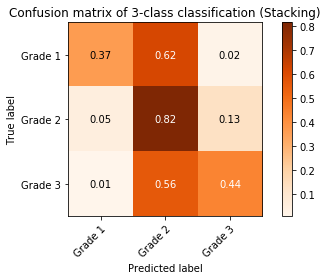

In [81]:
y_pred = best_sclf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
classes = np.asarray(['Grade 1', 'Grade 2', 'Grade 3'])

plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=True,
                          title='Confusion matrix of 3-class classification (Stacking)',
                          cmap='Oranges')

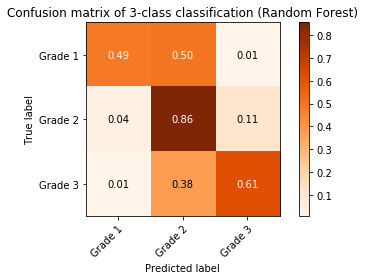

In [82]:
rf_clf = best_sclf.classifiers[0]
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)


cm = confusion_matrix(y_test, y_pred)
classes = np.asarray(['Grade 1', 'Grade 2', 'Grade 3'])

plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=True,
                          title='Confusion matrix of 3-class classification (Random Forest)',
                          cmap='Oranges')
print("F1-score: {}".format(f1_score(y_test, y_pred, average='micro')))

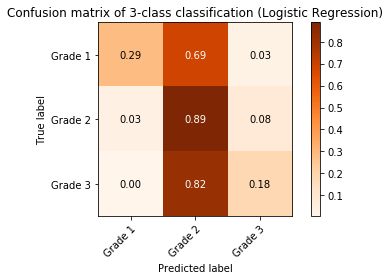

In [83]:
lr_clf = best_sclf.classifiers[1]
lr_clf.fit(X_train, y_train)

y_pred = lr_clf.predict(X_test)


cm = confusion_matrix(y_test, y_pred)
classes = np.asarray(['Grade 1', 'Grade 2', 'Grade 3'])

plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=True,
                          title='Confusion matrix of 3-class classification (Logistic Regression)',
                          cmap='Oranges')
print("F1-score: {}".format(f1_score(y_test, y_pred, average='micro')))

In [84]:
weights = round(y_train.value_counts().max()/y_train.value_counts()).astype(int)
print(y_train.value_counts())
weight_dict = {2: 1, 3: 2, 1: 6}

In [85]:
rf_clf = best_sclf.classifiers[0]
rf_clf.set_params(pipeline__randomforestclassifier__class_weight=weight_dict)
rf_clf.fit(X_train, y_train)

y_pred = rf_clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
classes = np.asarray(['Grade 1', 'Grade 2', 'Grade 3'])

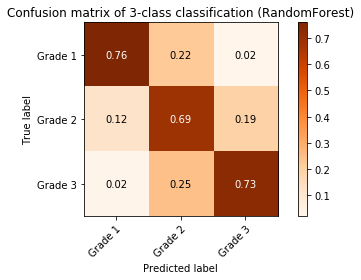

In [86]:
plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=True,
                          title='Confusion matrix of 3-class classification (RandomForest)',
                          cmap='Oranges')
print("F1-score: {}".format(f1_score(y_test, y_pred, average='micro')))

In [87]:
lr_clf = best_sclf.classifiers[1]
lr_clf.set_params(logisticregression__class_weight=weight_dict)
lr_clf.fit(X_train, y_train)

y_pred = lr_clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
classes = np.asarray(['Grade 1', 'Grade 2', 'Grade 3'])

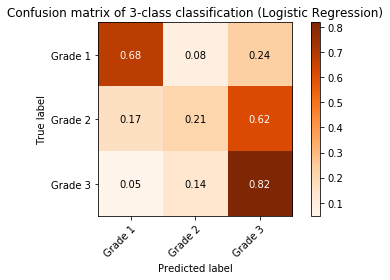

In [88]:
plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=True,
                          title='Confusion matrix of 3-class classification (Logistic Regression)',
                          cmap='Oranges')
print("F1-score: {}".format(f1_score(y_test, y_pred, average='micro')))

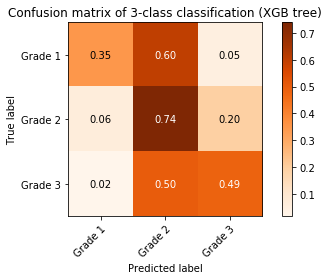

In [89]:
xgb_clf = best_sclf.classifiers[2]

y_pred = xgb_clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
classes = np.asarray(['Grade 1', 'Grade 2', 'Grade 3'])
plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=True,
                          title='Confusion matrix of 3-class classification (XGB tree)',
                          cmap='Oranges')
print("F1-score: {}".format(f1_score(y_test, y_pred, average='micro')))

# References

https://blog.statsbot.co/ensemble-learning-d1dcd548e936
